The main goal of this notebook is to scrape Data Scientist job vacancy from [Jobstreet Malaysia](https://www.jobstreet.com.my/)(a job searching website). We'll be using the combination API and manual HTML scraping technique from the Jobstreet for our webscraping.


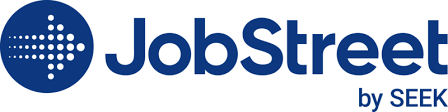

## Install and import packages [](#1)

In [1]:
!pip install wordcloud contractions

  Obtaining dependency information for anyascii from https://files.pythonhosted.org/packages/4f/7b/a9a747e0632271d855da379532b05a62c58e979813814a57fa3b3afeb3a4/anyascii-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for pyahocorasick from https://files.pythonhosted.org/packages/dc/5b/dd290b77c190f334dc0de4aae20dee58e25daca8dc46137178b24034edef/pyahocorasick-2.0.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

## Scraping function [](#2)

In [3]:
def scrape_article_ids(api_url, max_pages):
    job_id =[]
    titles = []
    companies = []
    locations = []
    categorys= []
    subCategorys= []
    job_types=[]
    salarys=[]
    for page_number in range(1, max_pages + 1):
        page_url = f'{api_url}&page={page_number}'
        
        # Send an HTTP request to the API endpoint
        response = requests.get(api_url)
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()

            # Extract advertiser IDs from each item in the 'data' list
            for item in data['data']:
                #print(item)
                jid = item['id']
                title = item['title']
                company = item['advertiser'].get('description', '')
                location = item.get('location', '')
                category = item['classification'].get('description', '')
                subCategory= item['subClassification'].get('description', '')
                job_type = item.get('workType', '')
                salary = item.get('salary', '')

                job_id.append(jid)
                titles.append(title)
                companies.append(company)
                locations.append(location)
                categorys.append(category)
                subCategorys.append(subCategory)
                job_types.append(job_type)
                salarys.append(salary)
                #print(f"Job ID: {job_id}")

        else:
            print(f"Failed to retrieve data from the API. Status Code: {response.status_code}")
            break

    return job_id, titles, companies, locations, categorys, subCategorys,job_types,salarys


max_pages = 3

# api url taken from Network -> Header 
api_url = 'https://www.jobstreet.com.my/api/chalice-search/v4/search?siteKey=MY-Main&sourcesystem=houston&userqueryid=2b00edd417ec163434fca9421e24c97a-7428735&userid=e56c7e89-1d1a-42b9-b7a5-37c12653d6b9&usersessionid=e56c7e89-1d1a-42b9-b7a5-37c12653d6b9&eventCaptureSessionId=e56c7e89-1d1a-42b9-b7a5-37c12653d6b9&seekSelectAllPages=true&keywords=data+scientist&pageSize=99&include=seodata&locale=en-MY&solId=568d2fe8-e8ef-4998-8e24-3e1ccfb1348b'
job_id, titles, companies, locations, categorys, subCategorys,job_types,salarys = scrape_article_ids(api_url, max_pages)


## Fetch job descriptions from individual job link

In [4]:
def fetch_job_article(job_id):
    article_url = f'https://www.jobstreet.com.my/job/{job_id}'
    response = requests.get(article_url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to retrieve job article. Status Code: {response.status_code}")
        return None

def extract_text_from_ul(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    ul_tags = soup.find_all('ul')
    text_list = [ul.get_text(separator='\n') for ul in ul_tags]
    return '\n'.join(text_list)

def scrape_and_store_text(job_ids):
    data = {'job_id': [],'job_title':[],'company':[], 'descriptions': [], 'location':[],'category':[],'subcategory':[],'type':[],'salary':[]}

    for job_id in job_ids:
        job_article_content = fetch_job_article(job_id)
        
        if job_article_content:
            text_from_ul = extract_text_from_ul(job_article_content)
            data['job_id'].append(job_id)
            data['descriptions'].append(text_from_ul)

    data['job_title'] = titles
    data['company'] = companies
    data['location'] = locations 
    data['category'] = categorys
    data['subcategory'] = subCategorys
    data['type']=job_types
    data['salary']=salarys
    
    
    return data

# print("Length of job_ids:", len(job_ids))
# print("Length of job_types:", len(job_types))
# print("Length of salarys:", len(salarys))


In [5]:
data = scrape_and_store_text(job_id)
result_df = pd.DataFrame(data)
result_df

,job_id,job_title,company,descriptions,location,category,subcategory,type,salary
0,73787445,Data Scientist,Nexperia Malaysia Sdn.Bhd.,"Understand needs of factory, manufacturing process , data availability and avenues for improvement\nDefine , together with engineering, manufacturing and quality problems that can be solved using ...",Seremban District,Information & Communication Technology,Database Development & Administration,Full time,
1,73794783,Data Scientist (Hybrid Working),SEEK,"Forming clear data addressable problem statements from current business problems\nGathering, validating and understanding data relevant to the problem statement\nDesigning and building data transf...",Kuala Lumpur,Science & Technology,"Mathematics, Statistics & Information Sciences",Full time,
2,73823368,"Lead Analyst, Data Science and Analytics",Labuan Financial Services Authority (Labuan FSA),"Steer data-driven culture across all-level business in Labuan FSA and advising on IT environments, tools and technologies related to data.\nReview and intensify short-term data analytics proof-of-...",Labuan,Banking & Financial Services,Analysis & Reporting,Full time,"RM 7,200 – RM 10,800 per month"
3,73765897,R&D Engineer (Data Scientist),Agmo Studio Sdn Bhd,"Strong programming skills in relevant languages such as Python\nFamiliarity with data manipulation and analysis using tools such as pandas, NumPy, and scikit-learn\nUnderstanding of statistical co...",Petaling,Information & Communication Technology,Engineering - Software,Full time,"RM 3,500 – RM 5,000 per month"
4,73625262,Agricultural Data Scientist,Applied Agricultural Resources Sdn. Bhd.,"Collect and analyse data related to plantations and agriculture to support decision-making.\nApply statistical analysis, machine learning algorithms, simulations, and predictive modelling techniqu...",Petaling,Science & Technology,"Mathematics, Statistics & Information Sciences",Full time,"RM 4,700 – RM 7,050 per month"
...,...,...,...,...,...,...,...,...,...
298,73630312,Lead System Analyst (Java),Ambition Group Malaysia Sdn Bhd,"Skilled in analyzing user requirements and translating them into comprehensive design documents, ensuring clarity and accuracy.\nEvaluate and analyze existing interactions and processes to identif...",Kuala Lumpur,Information & Communication Technology,Business/Systems Analysts,Full time,$15000.00 - $20000.00 p.a.
299,73453928,"Data Analyst, Asia",QBE ASIA SERVICES SDN. BHD.,"Develop and refine analytical use cases with internal business customers in alignment with Analytics leads and partners\nPlay an active role on projects of diverse scope, range, priority and urgen...",Petaling,Information & Communication Technology,Business/Systems Analysts,Full time,
300,73481414,Data Analyst,Private Advertiser,\n\nInsights on salary & in-demand skills\n\n\nReviews from people working in the industry\n\n,Kuala Lumpur,Information & Communication Technology,Database Development & Administration,Full time,
301,73491028,System Analyst (IT),Flash Express,"Understanding the whole company product line, function, and feature\nContact, coordinate and collect the needs of department. Analyse and propose a suitable system development plan for department ...",Bangsar South,Information & Communication Technology,Help Desk & IT Support,Full time,


In [6]:
for key, value in data.items():
    print(f"Length of {key}: {len(value)}") 

Length of job_id: 303
Length of job_title: 303
Length of company: 303
Length of descriptions: 303
Length of location: 303
Length of category: 303
Length of subcategory: 303
Length of type: 303
Length of salary: 303


In [7]:
result_df['date_ingestion'] = pd.to_datetime('today')

In [8]:
dataset_filename = "/kaggle/input/data-scientist-job-webscrape/data_scientist_jobstreet_scraped_v2.csv"
new_filename = "data_scientist_jobstreet_scraped_v2.csv"

def updateData():
    previous_df = pd.read_csv(dataset_filename, index_col=0)
    
    number_wines_before = previous_df.shape[0]

    rows_to_concat = []

    for index, row in result_df.iterrows():
        r = previous_df.loc[(previous_df['job_id'] == row['job_id']) & (previous_df['company'] == row['company'])]
        #print(row)
        if r.empty:
            rows_to_concat.append(row)

    if rows_to_concat:
        rows_df = pd.DataFrame(rows_to_concat)  # Convert list of rows to a DataFrame
        previous_df = pd.concat([previous_df, rows_df], ignore_index=True)

    number_wines_after = previous_df.shape[0]
    print('{} wines added'.format(number_wines_after - number_wines_before))

    previous_df.to_csv(new_filename)
    
    return previous_df

In [9]:
import os
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
apitoken = user_secrets.get_secret("kaggle")

# os.environ["KAGGLE_CONFIG_DIR"] = "/root/.kaggle"
# with open("/root/.kaggle/kaggle.json", "w") as file:
#     file.write(apitoken)
# !mkdir -p ~/.kaggle
# %store apitoken >~/.kaggle/kaggle.json
# !mkdir -p dataset

In [10]:
slug = 'data-scientist-job-webscrape'

In [11]:
def fetchDataset():
    !kaggle datasets metadata azraimohamad/data-scientist-job-webscrape -p dataset
    !kaggle datasets download -d azraimohamad/data-scientist-job-webscrape
    !unzip -o azraimohamad/data-scientist-job-webscrape -d dataset

def updateDataset():
    !kaggle datasets version -p dataset -m "Update"

In [12]:
#fetchDataset()
update_df = updateData()
#updateDataset()

303 wines added


## Read Scraped job data

In [13]:
result_df= pd.read_csv("/kaggle/working/data_scientist_jobstreet_scraped_v2.csv", index_col=0)
result_df

,job_id,job_title,company,descriptions,location,category,subcategory,type,salary,date_ingestion
0,72761527,Data Engineer,ANHSIN TECHNOLOGY SDN BHD,"Design, develop, and maintain scalable and robust data architecture.\nCreate and manage databases, data processing systems, and data integration solutions.\nDevelop and implement efficient ETL pro...",Kuala Lumpur,Science & Technology,"Mathematics, Statistics & Information Sciences",Full time,NaN,NaN
1,72787241,Machine Learning Engineer (AI),Accordia Global Sdn Bhd,"Design, develop, and deploy machine learning models for our AI assistants\nWork with data scientists and engineers to build and maintain our data pipelines and infrastructure\nEvaluate and improve...",Shah Alam/Subang,Science & Technology,"Mathematics, Statistics & Information Sciences",Full time,"RM 5,000 – RM 7,000 per month",NaN
2,72866732,Senior Risk/Data Analyst,Toyota Capital Malaysia Sdn. Bhd.,"Analyse data to better understand potential risks, concerns and outcomes of decisions.\nAggregate data from multiple sources to provide a comprehensive assessment.\nCreate reports, summaries, pres...",Petaling,Banking & Financial Services,Compliance & Risk,Full time,NaN,NaN
3,72851872,Senior Data Engineer (Hybrid Working),SEEK,"Design, development, testing, and operation of:\nBig data processing pipelines\nTools for managing and monitoring data systems and processes, including quality, security, lifecycle\nDeploy, operat...",Kuala Lumpur,Information & Communication Technology,Engineering - Software,Full time,NaN,NaN
4,72526811,Data Scientist (Hybrid Working),SEEK Asia (JobStreet),"Research, build, deploy and maintain Recommendations AI solutions integrated with recruitment products aiming to properly connect candidates to recruiters\nImprove the chances of matching (job pla...",Kuala Lumpur,Information & Communication Technology,Developers/Programmers,Full time,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
904,73630312,Lead System Analyst (Java),Ambition Group Malaysia Sdn Bhd,"Skilled in analyzing user requirements and translating them into comprehensive design documents, ensuring clarity and accuracy.\nEvaluate and analyze existing interactions and processes to identif...",Kuala Lumpur,Information & Communication Technology,Business/Systems Analysts,Full time,$15000.00 - $20000.00 p.a.,2024-02-19 11:51:42.737551
905,73453928,"Data Analyst, Asia",QBE ASIA SERVICES SDN. BHD.,"Develop and refine analytical use cases with internal business customers in alignment with Analytics leads and partners\nPlay an active role on projects of diverse scope, range, priority and urgen...",Petaling,Information & Communication Technology,Business/Systems Analysts,Full time,NaN,2024-02-19 11:51:42.737551
906,73481414,Data Analyst,Private Advertiser,\n\nInsights on salary & in-demand skills\n\n\nReviews from people working in the industry\n\n,Kuala Lumpur,Information & Communication Technology,Database Development & Administration,Full time,NaN,2024-02-19 11:51:42.737551
907,73491028,System Analyst (IT),Flash Express,"Understanding the whole company product line, function, and feature\nContact, coordinate and collect the needs of department. Analyse and propose a suitable system development plan for department ...",Bangsar South,Information & Communication Technology,Help Desk & IT Support,Full time,NaN,2024-02-19 11:51:42.737551


## Basic EDA 😃

In [14]:
import nltk
import matplotlib.pyplot as plt
import contractions
import regex as re
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

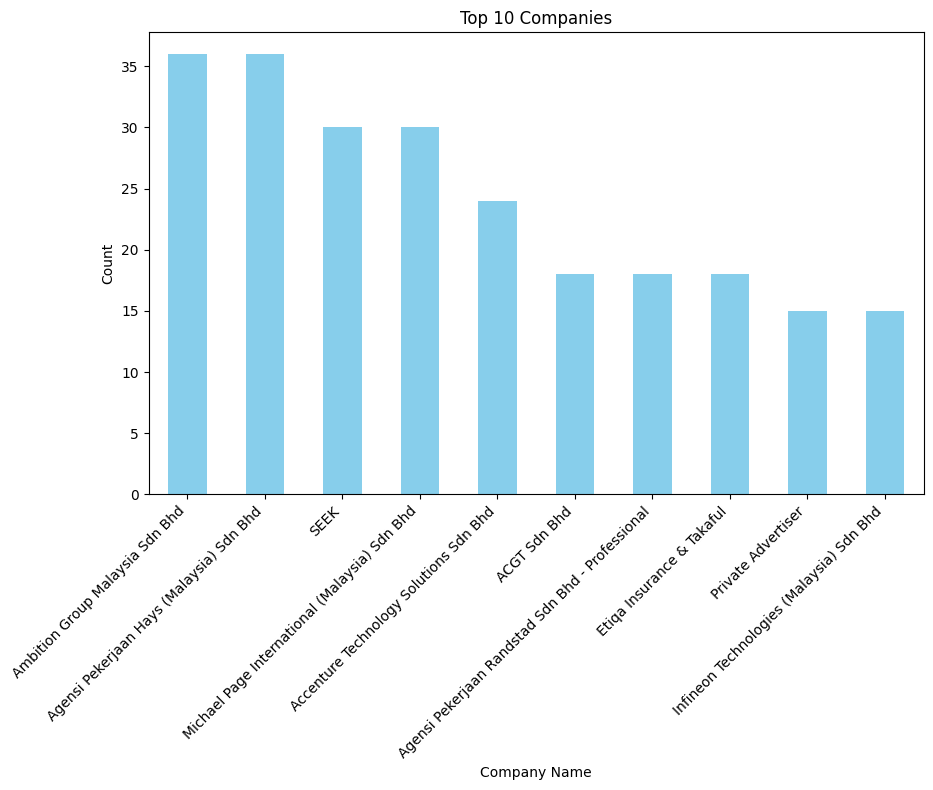

In [15]:
top_companies = result_df['company'].value_counts()[:10]

# Plotting
plt.figure(figsize=(10, 6))
top_companies.plot(kind='bar', color='skyblue')
plt.title('Top 10 Companies')
plt.xlabel('Company Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

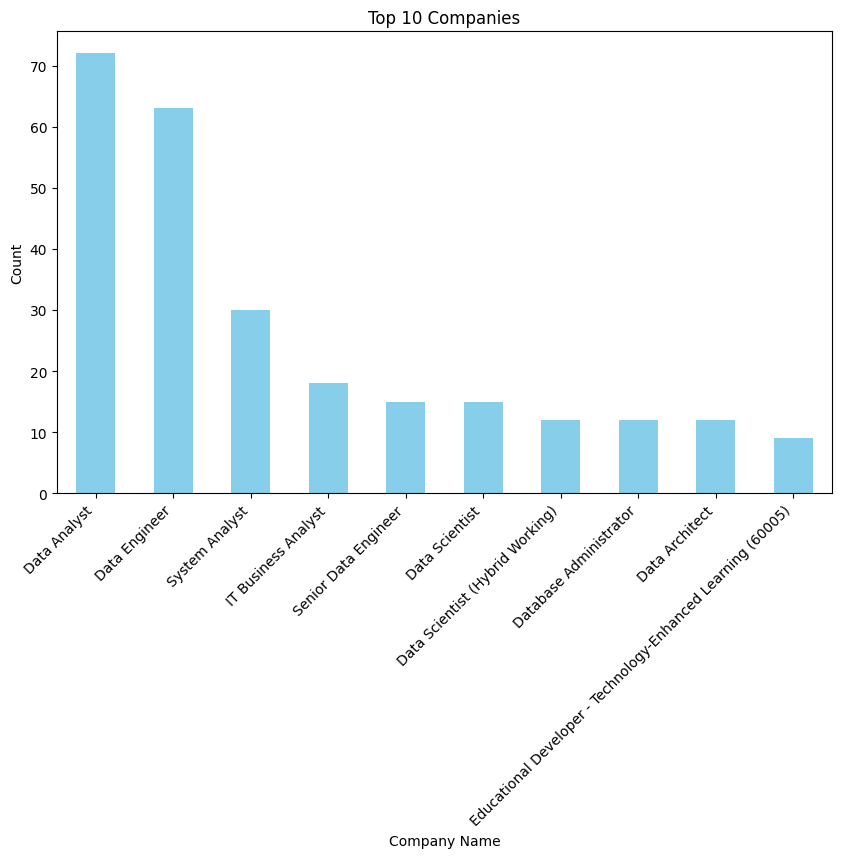

In [16]:
top_companies = result_df['job_title'].value_counts()[:10]

# Plotting
plt.figure(figsize=(10, 6))
top_companies.plot(kind='bar', color='skyblue')
plt.title('Top 10 Companies')
plt.xlabel('Company Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

<Axes: xlabel='Job Description length', ylabel='No. of jobs'>

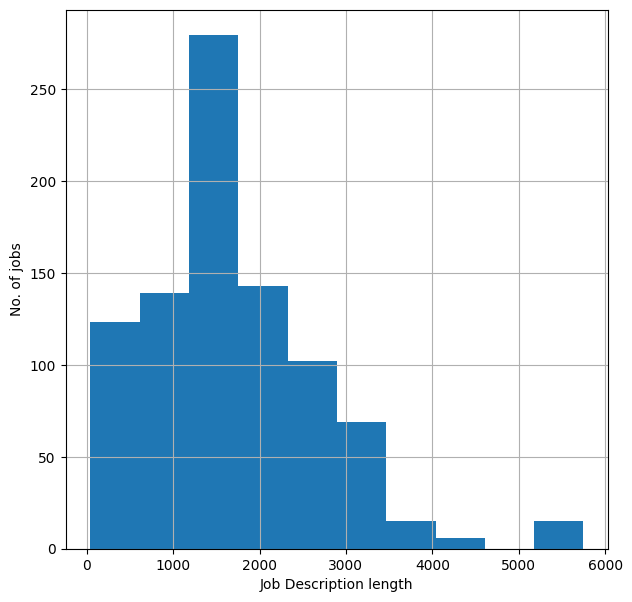

In [17]:
# visualizing Job Description length
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.xlabel("Job Description length")
plt.ylabel("No. of jobs")

result_df['descriptions'].str.len().hist()

In [18]:
result_df['requirements'] = result_df['descriptions'].apply(lambda x: [contractions.fix(word) for word in str(x).split()])
result_df['requirements'] = [' '.join(map(str, l)) for l in result_df['requirements']]

result_df.sample(5, random_state = 5)

,job_id,job_title,company,descriptions,location,category,subcategory,type,salary,date_ingestion,requirements
28,72662959,"Principal Engineer, Automation Project",Analog Devices Sdn. Bhd.,Develop and execute a comprehensive automation strategy that aligns with the organization's overall manufacturing objectives and Industrial 4.0 principles.\nLead the implementation and integration...,Penang Island,Engineering,Electrical/Electronic Engineering,Full time,"RM 12,000 – RM 17,000 per month",NaN,Develop and execute a comprehensive automation strategy that aligns with the organization's overall manufacturing objectives and Industrial 4.0 principles. Lead the implementation and integration ...
275,72531370,ERP Analyst / Application Analyst,Amazon Papyrus (M) Sdn Bhd,"Based in Malaysia, Work from home arrangement\nERP / Application Support, & Project implementation\nFun & stable, MNC environment\nIn-house, 5-day work, Medical insurance, Discretionary bonus\nAs ...",Kuala Lumpur,Information & Communication Technology,Business/Systems Analysts,Full time,NaN,NaN,"Based in Malaysia, Work from home arrangement ERP / Application Support, & Project implementation Fun & stable, MNC environment In-house, 5-day work, Medical insurance, Discretionary bonus As a Ke..."
365,72540519,Data Analyst,Global Parcel Service (M) Sdn Bhd,"Growth opportunities\nInternational vision\nPromising career development\n Develop and automate dashboards, analyses, and reports to support business functions. \n Collaborate with stakeholders in...",Petaling,"Manufacturing, Transport & Logistics",Analysis & Reporting,Full time,"RM 3,500 – RM 5,000 per month",NaN,"Growth opportunities International vision Promising career development Develop and automate dashboards, analyses, and reports to support business functions. Collaborate with stakeholders in Operat..."
787,73678753,Learning Specialist,Technip Energies,"Works with managers to identify team and individual capability levels and gaps.\nRecommends suitable learning options to meet individual and team requirements, considering appropriate delivery cha...",Kuala Lumpur,Human Resources & Recruitment,Training & Development,Full time,NaN,2024-02-19 11:51:42.737551,"Works with managers to identify team and individual capability levels and gaps. Recommends suitable learning options to meet individual and team requirements, considering appropriate delivery chan..."
484,72288343,Internship (Data Analyst),J&T CARGO,Responsible for handling the enquiries between internal and external.\nResponsible for handling the primary point of contact between direct sales and the company to ensure any issues/concerns are ...,Petaling,Science & Technology,"Mathematics, Statistics & Information Sciences",Contract/Temp,NaN,NaN,Responsible for handling the enquiries between internal and external. Responsible for handling the primary point of contact between direct sales and the company to ensure any issues/concerns are r...


In [19]:
result_df.isnull().any()

job_id            False
job_title         False
company           False
descriptions       True
location          False
category          False
subcategory       False
type              False
salary             True
date_ingestion     True
requirements      False
dtype: bool

## 📌Basic text processing

In [20]:
result_df['requirements'] = result_df['requirements'].str.lower()
result_df['requirements'] = result_df['requirements'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))
result_df['tokenized_desc'] = result_df['requirements'].apply(word_tokenize)
#result_df.sample(5, random_state = 5)

In [21]:
#remove stopwords 

result_df['tokenized_desc'] = result_df['tokenized_desc'].apply(lambda x: [word for word in x if word not in stop_words])
result_df['tokenized_desc_join'] = [' '.join(map(str, l)) for l in result_df['tokenized_desc']]

#result_df.sample(5, random_state = 5)

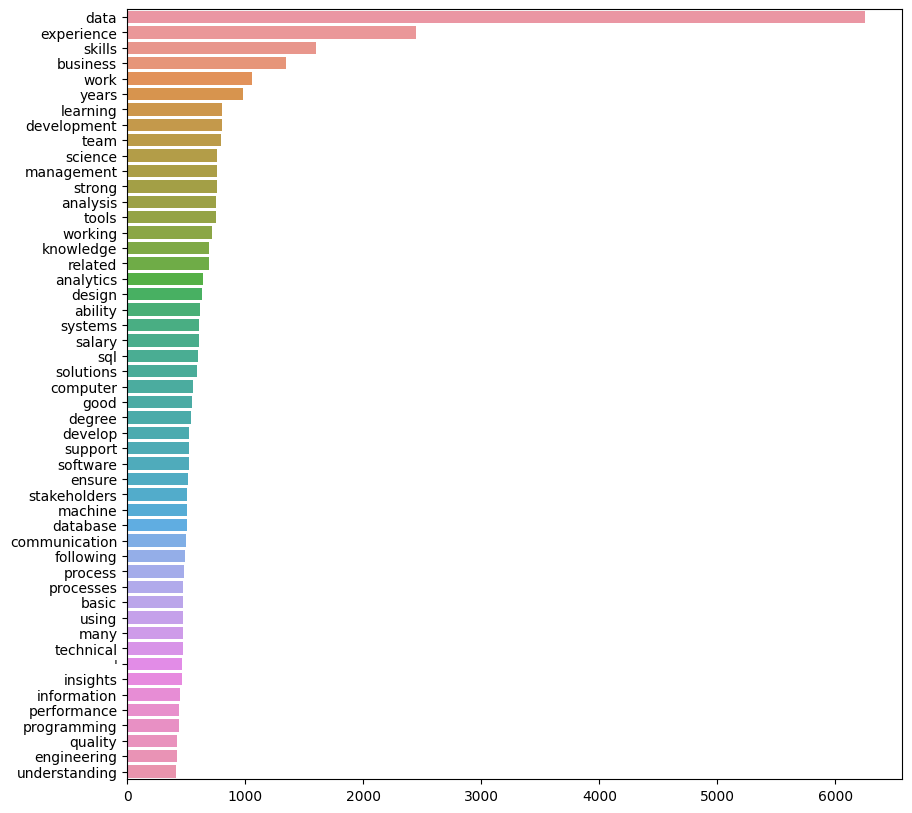

In [22]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(result_df['tokenized_desc_join'])

## Bi-gram

In [23]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

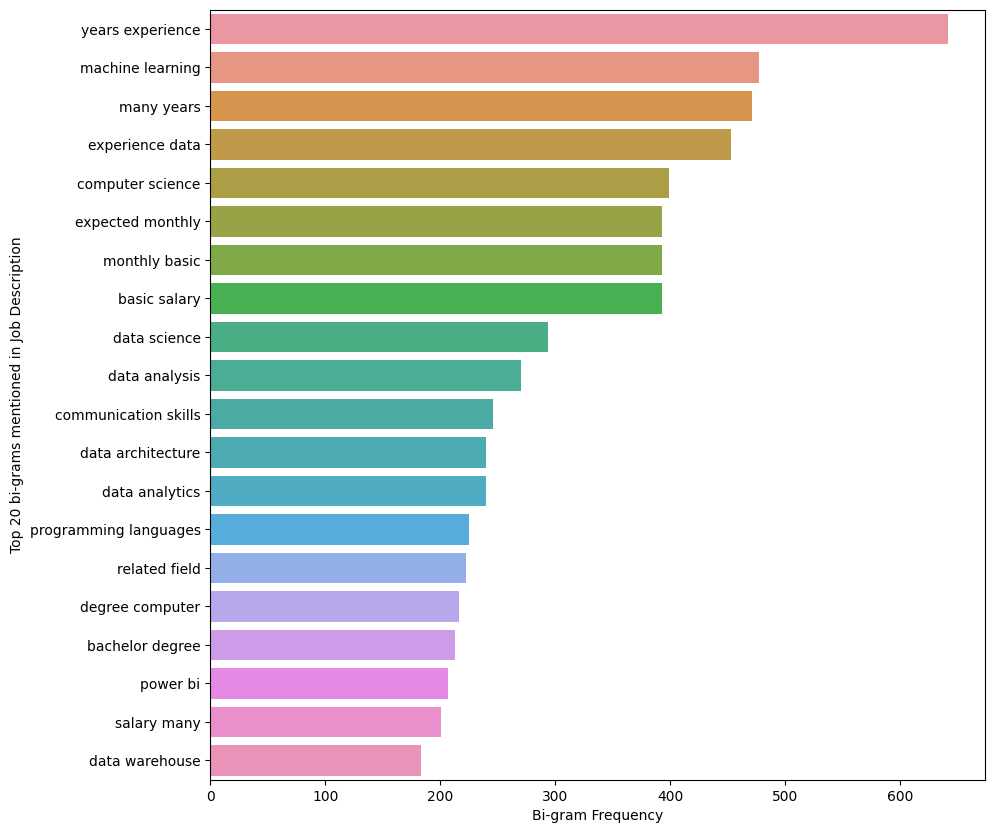

In [24]:

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Bi-gram Frequency")
    plt.ylabel("Top 20 bi-grams mentioned in Job Description")
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(result_df['tokenized_desc_join'],2)

## Tri-gram

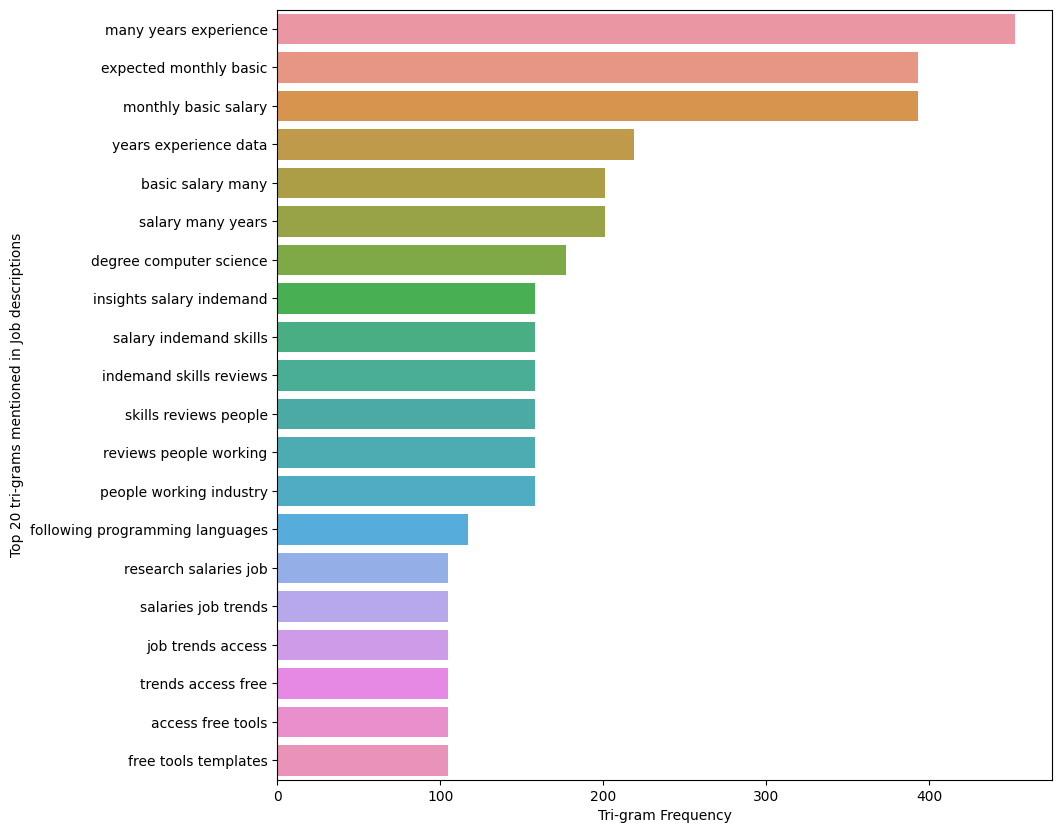

In [25]:
#Tri-grams 

def plot_top_ngrams_barchart(text, n=3):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]

    top_n_bigrams=_get_top_ngram(text,n)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    plt.xlabel("Tri-gram Frequency")
    plt.ylabel("Top 20 tri-grams mentioned in Job descriptions")
    sns.barplot(x=y,y=x)


plot_top_ngrams_barchart(result_df['tokenized_desc_join'],3)

## Word Cloud

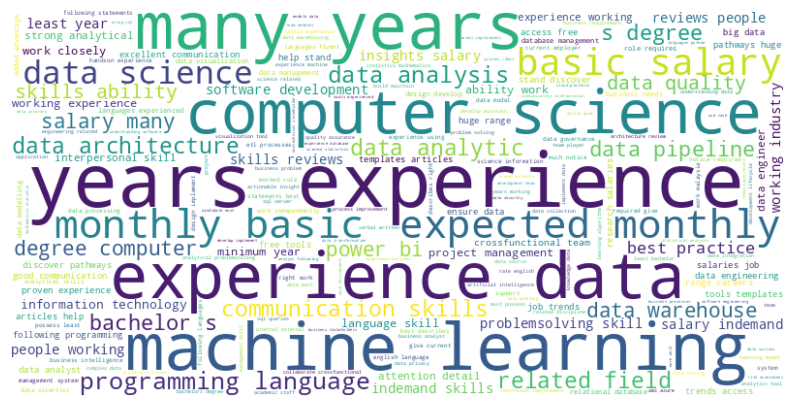

In [26]:
from wordcloud import WordCloud

text_data = ' '.join(result_df['tokenized_desc_join'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
result_df.drop(columns=['requirements','tokenized_desc'], inplace=True)

In [28]:
result_df.head()

,job_id,job_title,company,descriptions,location,category,subcategory,type,salary,date_ingestion,tokenized_desc_join
0,72761527,Data Engineer,ANHSIN TECHNOLOGY SDN BHD,"Design, develop, and maintain scalable and robust data architecture.\nCreate and manage databases, data processing systems, and data integration solutions.\nDevelop and implement efficient ETL pro...",Kuala Lumpur,Science & Technology,"Mathematics, Statistics & Information Sciences",Full time,NaN,NaN,design develop maintain scalable robust data architecture create manage databases data processing systems data integration solutions develop implement efficient etl processes data ingestion transf...
1,72787241,Machine Learning Engineer (AI),Accordia Global Sdn Bhd,"Design, develop, and deploy machine learning models for our AI assistants\nWork with data scientists and engineers to build and maintain our data pipelines and infrastructure\nEvaluate and improve...",Shah Alam/Subang,Science & Technology,"Mathematics, Statistics & Information Sciences",Full time,"RM 5,000 – RM 7,000 per month",NaN,design develop deploy machine learning models ai assistants work data scientists engineers build maintain data pipelines infrastructure evaluate improve performance ai assistants collaborate produ...
2,72866732,Senior Risk/Data Analyst,Toyota Capital Malaysia Sdn. Bhd.,"Analyse data to better understand potential risks, concerns and outcomes of decisions.\nAggregate data from multiple sources to provide a comprehensive assessment.\nCreate reports, summaries, pres...",Petaling,Banking & Financial Services,Compliance & Risk,Full time,NaN,NaN,analyse data better understand potential risks concerns outcomes decisions aggregate data multiple sources provide comprehensive assessment create reports summaries presentations process documents...
3,72851872,Senior Data Engineer (Hybrid Working),SEEK,"Design, development, testing, and operation of:\nBig data processing pipelines\nTools for managing and monitoring data systems and processes, including quality, security, lifecycle\nDeploy, operat...",Kuala Lumpur,Information & Communication Technology,Engineering - Software,Full time,NaN,NaN,design development testing operation big data processing pipelines tools managing monitoring data systems processes including quality security lifecycle deploy operate support data infrastructure ...
4,72526811,Data Scientist (Hybrid Working),SEEK Asia (JobStreet),"Research, build, deploy and maintain Recommendations AI solutions integrated with recruitment products aiming to properly connect candidates to recruiters\nImprove the chances of matching (job pla...",Kuala Lumpur,Information & Communication Technology,Developers/Programmers,Full time,NaN,NaN,research build deploy maintain recommendations ai solutions integrated recruitment products aiming properly connect candidates recruiters improve chances matching job placements leverage ai platfo...
